# A Content-Based Product Recommendation Engine for Amazon Products

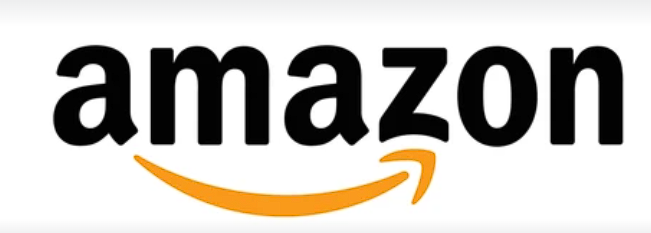

# Overview:

The Amazon Product Recommendation System is a content-based recommendation engine designed to enhance user experience by providing personalized product suggestions. This system uses the metadata of products (like names, ratings, prices, etc.) to determine the similarity between items and recommend alternatives. It serves as a robust, scalable solution for e-commerce platforms to improve customer engagement and satisfaction.


* **Goals and Objectives:**
    1.   Provide Personalized Recommendations:Suggest products similar to the one the user is viewing.
    2.   Ensure recommendations align with the user’s preferences and purchase intent.
* **Content-Based Approach:**
    1.  Focus on item metadata for recommendation.
    2.  Eliminate the dependency on user purchase history or collaborative filtering methods.
* **Scalability and Efficiency:**
    1. Support large datasets with minimal memory usage.
    2. Generate recommendations quickly without performance degradation.


In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-products-dataset/Gaming Consoles.csv
/kaggle/input/amazon-products-dataset/Car Electronics.csv
/kaggle/input/amazon-products-dataset/Janitorial and Sanitation Supplies.csv
/kaggle/input/amazon-products-dataset/All Electronics.csv
/kaggle/input/amazon-products-dataset/All Books.csv
/kaggle/input/amazon-products-dataset/Make-up.csv
/kaggle/input/amazon-products-dataset/Travel Accessories.csv
/kaggle/input/amazon-products-dataset/Indian Language Books.csv
/kaggle/input/amazon-products-dataset/Car and Bike Care.csv
/kaggle/input/amazon-products-dataset/Sunglasses.csv
/kaggle/input/amazon-products-dataset/Bags and Luggage.csv
/kaggle/input/amazon-products-dataset/Yoga.csv
/kaggle/input/amazon-products-dataset/Sportswear.csv
/kaggle/input/amazon-products-dataset/Fiction Books.csv
/kaggle/input/amazon-products-dataset/Exam Central.csv
/kaggle/input/amazon-products-dataset/Home Storage.csv
/kaggle/input/amazon-products-dataset/Toys Gifting Store.csv
/kaggle/input/amazon-pr

In [2]:
pd.set_option('max_colwidth', 400)

# All Electronics Recommendation Engine

In [3]:
import pandas as pd
import numpy as np
import re
import sys
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis (EDA)

In [4]:
FILE_PATH = "/kaggle/input/amazon-products-dataset/All Electronics.csv"
prod_df = pd.read_csv(FILE_PATH)

print("Initial dataset shape:", prod_df.shape)

Initial dataset shape: (9600, 9)


In [5]:
FILE_PATH = "/kaggle/input/amazon-products-dataset/All Electronics.csv"
df = pd.read_csv(FILE_PATH)

print("Initial dataset shape:", prod_df.shape)
display(prod_df.head(3))

Initial dataset shape: (9600, 9)


,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJL._AC_UL320_.jpg,https://www.amazon.in/Redmi-Power-Black-128GB-Storage/dp/B09Y64H8VS/ref=sr_1_4?qid=1679133649&s=electronics&sr=1-4,4.0,965,"₹10,999","₹18,999"
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3VzqL._AC_UL320_.jpg,https://www.amazon.in/OnePlus-Nord-Lite-128GB-Storage/dp/B09WQYFLRX/ref=sr_1_5?qid=1679133649&s=electronics&sr=1-5,4.3,"113,956","₹18,999","₹19,999"
2,"OnePlus Bullets Z2 Bluetooth Wireless in Ear Earphones with Mic, Bombastic Bass - 12.4 Mm Drivers, 10 Mins Charge - 20 Hrs...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCpL._AC_UL320_.jpg,https://www.amazon.in/Oneplus-Bluetooth-Wireless-Earphones-Bombastic/dp/B09TVVGXWS/ref=sr_1_6?qid=1679133649&s=electronics&sr=1-6,4.2,"90,304","₹1,999","₹2,299"


In [6]:
print("Unique main_categories   :", prod_df['main_category'].unique())
print("Unique sub_categories    :", prod_df['sub_category'].unique())

Unique main_categories   : ['tv, audio & cameras']
Unique sub_categories    : ['All Electronics']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            9600 non-null   object
 1   main_category   9600 non-null   object
 2   sub_category    9600 non-null   object
 3   image           9600 non-null   object
 4   link            9600 non-null   object
 5   ratings         9505 non-null   object
 6   no_of_ratings   9505 non-null   object
 7   discount_price  9116 non-null   object
 8   actual_price    9530 non-null   object
dtypes: object(9)
memory usage: 675.1+ KB


In [8]:
df['ratings_cleaned'] = (
    df['ratings']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)  
    .replace('', np.nan)                    
    .astype(float)                          
)

df['no_of_ratings_cleaned'] = (
    df['no_of_ratings']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)  
    .replace('', np.nan)
    .astype(float)
)

df['discount_price_cleaned'] = (
    df['discount_price']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

df['actual_price_cleaned'] = (
    df['actual_price']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

df[['ratings_cleaned','no_of_ratings_cleaned','discount_price_cleaned','actual_price_cleaned']].describe()

,ratings_cleaned,no_of_ratings_cleaned,discount_price_cleaned,actual_price_cleaned
count,9481.000000,9481.000000,9116.000000,9.530000e+03
mean,4.077576,8881.106107,3694.571852,5.988337e+03
std,0.377189,28120.501153,15837.729420,6.721685e+04
min,1.000000,1.000000,10.000000,2.000000e+01
25%,3.900000,235.000000,299.000000,8.405000e+02
50%,4.100000,1174.000000,599.000000,1.495000e+03
75%,4.300000,5127.000000,1599.000000,3.399000e+03
max,5.000000,437651.000000,879899.000000,6.059807e+06


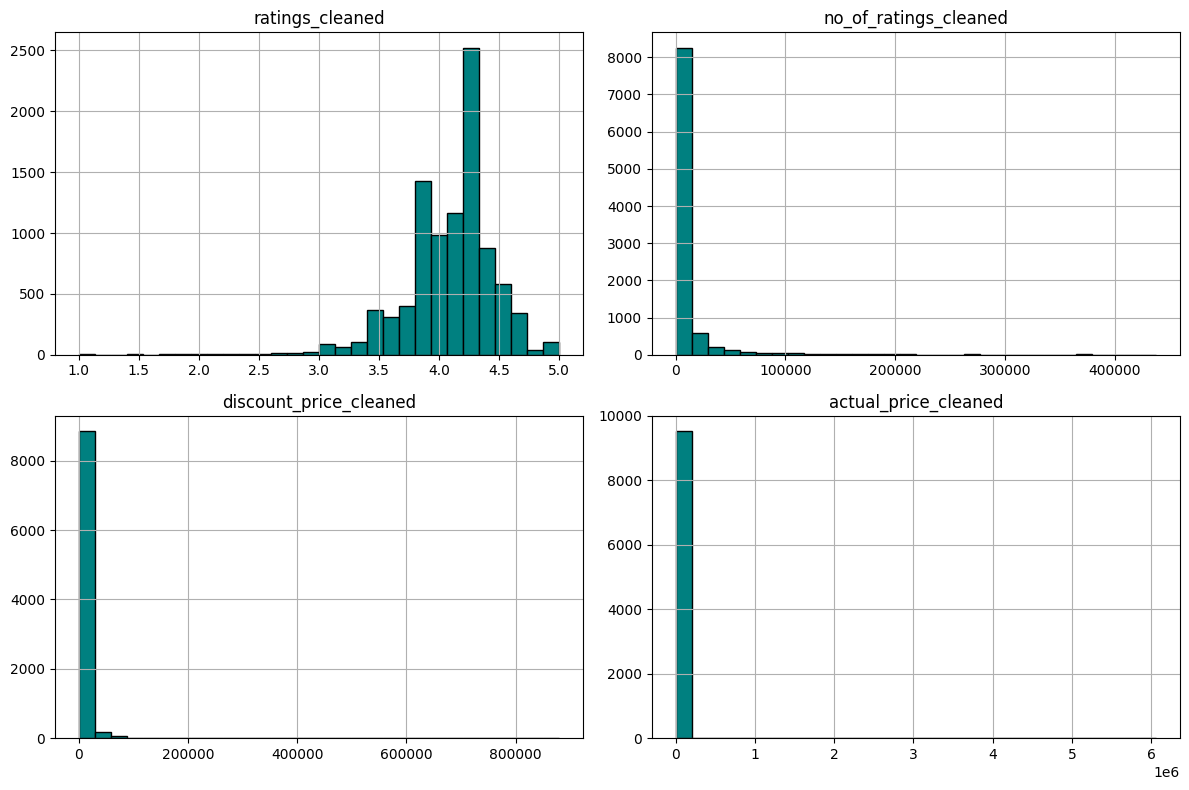

In [9]:
numeric_cols = ['ratings_cleaned','no_of_ratings_cleaned','discount_price_cleaned','actual_price_cleaned']
df[numeric_cols].hist(bins=30, figsize=(12,8), color='teal', edgecolor='black')
plt.tight_layout()
plt.show()

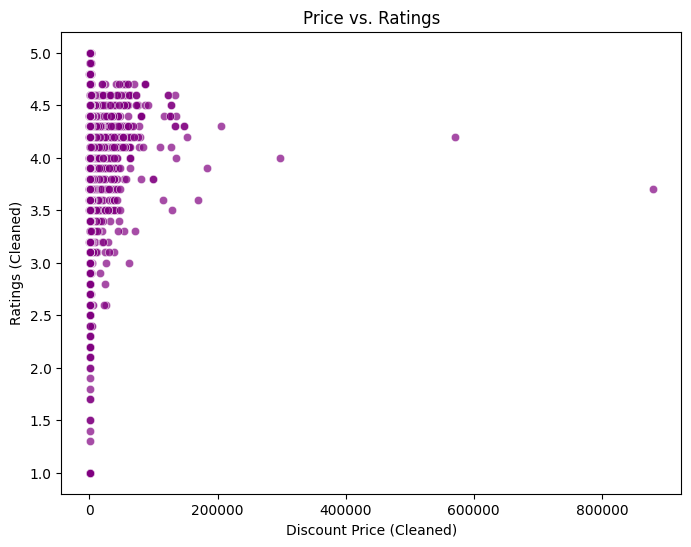

In [10]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df['discount_price_cleaned'], 
    y=df['ratings_cleaned'], 
    alpha=0.7, 
    color='purple'
)
plt.xlabel("Discount Price (Cleaned)")
plt.ylabel("Ratings (Cleaned)")
plt.title("Price vs. Ratings")
plt.show()

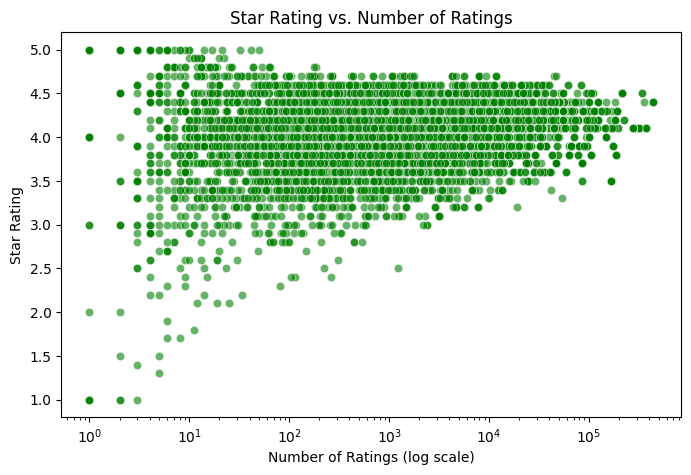

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=df['no_of_ratings_cleaned'], 
    y=df['ratings_cleaned'],
    alpha=0.6, 
    color='green'
)
plt.xscale('log')
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Star Rating")
plt.title("Star Rating vs. Number of Ratings")
plt.show()

In [12]:
top_10_rated = df.sort_values(by='no_of_ratings_cleaned', ascending=False).head(10)
display(top_10_rated[['name','no_of_ratings','ratings','discount_price','actual_price']])

,name,no_of_ratings,ratings,discount_price,actual_price
605,"Amazon Basics Flexible Premium HDMI Cable (Black, 4K@60Hz, 18Gbps), 3-Foot","437,651",4.4,₹269,₹700
2542,"Amazon Basics High-Speed HDMI Cable, 6 Feet (2-Pack),Black","437,651",4.4,₹349,"₹1,400"
470,"Amazon Basics High-Speed HDMI Cable - 10 Feet (Latest Standard) - Supports Ethernet, 3D, 4K video,Black","437,651",4.4,₹379,₹995
1217,"Amazon Basics High-Speed HDMI Cable, 6 Feet - Supports Ethernet, 3D, 4K video,Black","437,651",4.4,₹269,₹475
848,boAt Bassheads 100 Wired in Ear Earphones with Mic (Mint Orange),"375,110",4.1,₹399,₹999
170,boAt Bassheads 100 in Ear Wired Earphones with Mic(Furious Red),"375,110",4.1,₹399,₹999
280,boAt Bassheads 100 Wired in Ear Earphones with Mic (Mint Green),"375,110",4.1,₹399,₹999
382,boAt BassHeads 100 in-Ear Wired Headphones with Mic (White),"375,110",4.1,₹399,₹999
15,boAt BassHeads 100 in-Ear Wired Headphones with Mic (Black),"375,110",4.1,₹399,₹999
4365,"boAt BassHeads 100 Delhi Capitals Edition Wired in Ear Earphones with Super Extra Bass, with mic, Hawk Inspired Design and...","375,110",4.1,₹474,"₹1,499"


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


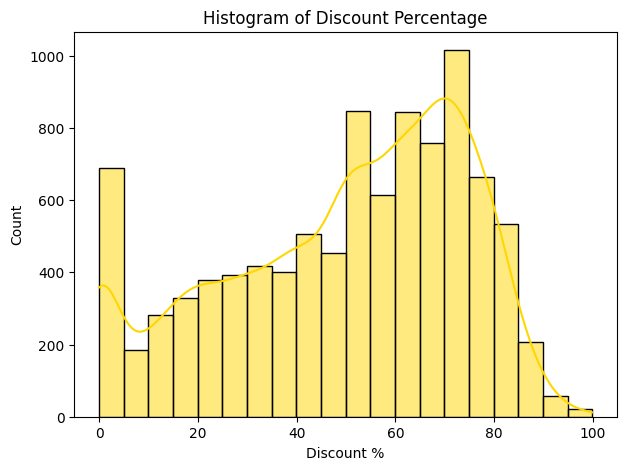

In [13]:
df['discount_diff'] = df['actual_price_cleaned'] - df['discount_price_cleaned']
df['discount_pct'] = (df['discount_diff'] / df['actual_price_cleaned']) * 100

df['discount_pct'] = df['discount_pct'].fillna(0).clip(lower=0, upper=100)

plt.figure(figsize=(7,5))
sns.histplot(df['discount_pct'], bins=20, color='gold', kde=True)
plt.title("Histogram of Discount Percentage")
plt.xlabel("Discount %")
plt.show()

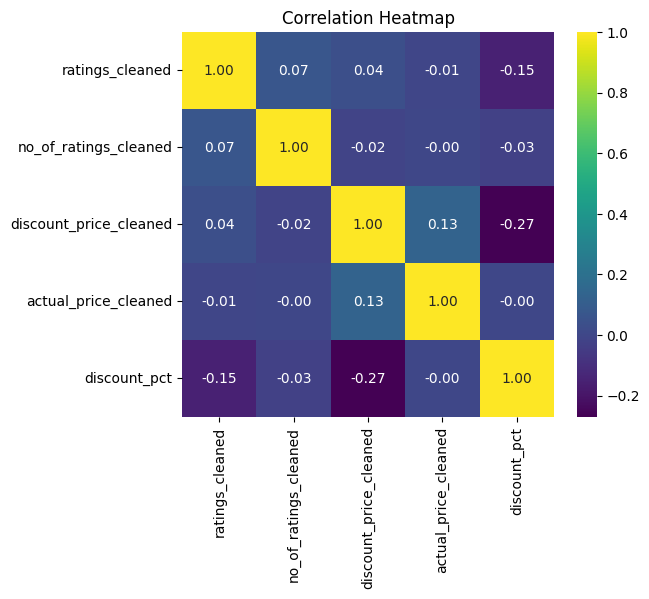

In [14]:
num_df = df[['ratings_cleaned','no_of_ratings_cleaned','discount_price_cleaned','actual_price_cleaned','discount_pct']]
corr_matrix = num_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [15]:
!pip install wordcloud

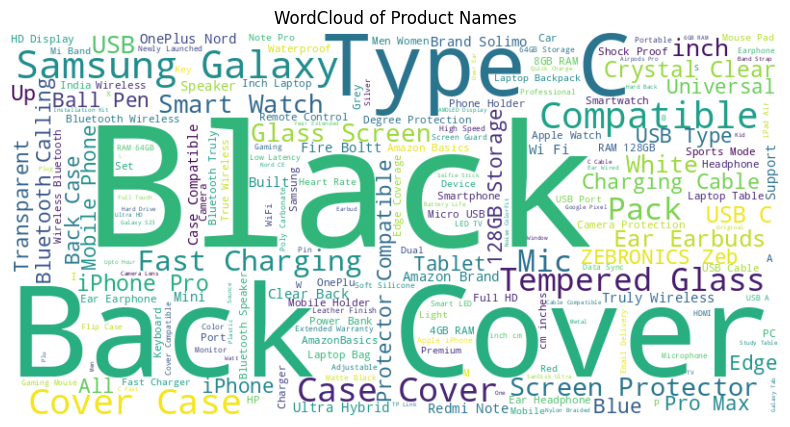

In [16]:
from wordcloud import WordCloud

all_names = " ".join(df['name'].astype(str).fillna(""))
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    stopwords={'with','for','and','in','to','of','the','by'}  # add any relevant stops
).generate(all_names)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Product Names")
plt.show()

In [17]:
def drop_unnecessary_columns(dataframe, drop_cols):
    """
    Removes columns that aren't needed for recommendation.
    """
    dataframe.drop(drop_cols, axis=1, inplace=True)
    return dataframe

drop_cols = ['main_category','sub_category']  
prod_df = drop_unnecessary_columns(prod_df, drop_cols)

In [18]:
duplicates_count = prod_df.duplicated().sum()
print("Number of duplicated rows:", duplicates_count)
if duplicates_count > 0:
    prod_df.drop_duplicates(inplace=True)

Number of duplicated rows: 0


In [19]:
prod_df.dropna(subset=['name'], inplace=True)

print("Shape after cleaning:", prod_df.shape)

Shape after cleaning: (9600, 7)


In [20]:
prod_df['search_terms'] = prod_df['name'].str.lower()
prod_df['search_terms'] = prod_df['search_terms'].str.replace(r'[^\w\d\s]+',' ', regex=True)

In [21]:
stemmer = PorterStemmer()

In [22]:
def stemming_function(sentence):
    """
    Applies stemming on each token in the sentence.
    """
    words = sentence.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

prod_df['search_terms'] = prod_df['search_terms'].apply(stemming_function)

In [23]:
display(prod_df[['name','search_terms']].head(3))

,name,search_terms
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB Storage)",redmi 10 power power black 8gb ram 128gb storag
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM, 128GB Storage)",oneplu nord ce 2 lite 5g blue tide 6gb ram 128gb storag
2,"OnePlus Bullets Z2 Bluetooth Wireless in Ear Earphones with Mic, Bombastic Bass - 12.4 Mm Drivers, 10 Mins Charge - 20 Hrs...",oneplu bullet z2 bluetooth wireless in ear earphon with mic bombast bass 12 4 mm driver 10 min charg 20 hr


In [24]:
vectorizer = CountVectorizer(
    max_features=5000,  
    stop_words='english',
    dtype=np.int8
)

feature_matrix = vectorizer.fit_transform(prod_df['search_terms'])
print("Feature matrix shape:", feature_matrix.shape)

Feature matrix shape: (9600, 5000)


In [25]:
similarities = cosine_similarity(feature_matrix)
print("Similarity matrix shape:", similarities.shape)

Similarity matrix shape: (9600, 9600)


In [26]:
def memory_in_mb(obj):
    """
    Returns memory usage of an object in megabytes.
    """
    return sys.getsizeof(obj)/1024/1024

print(f"Size of the similarity matrix: {memory_in_mb(similarities):.2f} MB")

Size of the similarity matrix: 703.13 MB


In [27]:
def build_top_neighbors_matrix(sim_matrix, k=10):
    """
    For each product, find the top-K neighbors (most similar),
    excluding the product itself. Return a 2D list/array of indices.
    """
    top_neighbors_list = []
    
    for row_idx in range(sim_matrix.shape[0]):
        sim_scores = list(enumerate(sim_matrix[row_idx]))
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_neighbors = sim_scores_sorted[1:k+1]
        top_neighbors_indices = [item[0] for item in top_neighbors]
        top_neighbors_list.append(top_neighbors_indices)
    
    return np.array(top_neighbors_list, dtype=np.int32)

start_time = time.time()
top_k_neighbors = build_top_neighbors_matrix(similarities, k=10)
end_time = time.time()

print(f"Time to build top-10 neighbors structure: {end_time - start_time:.3f} sec")
print("Shape of top_k_neighbors:", top_k_neighbors.shape)
print(f"Memory usage of top_k_neighbors: {memory_in_mb(top_k_neighbors):.2f} MB")

Time to build top-10 neighbors structure: 35.647 sec
Shape of top_k_neighbors: (9600, 10)
Memory usage of top_k_neighbors: 0.37 MB


In [28]:
del similarities

In [29]:
def shorten_image_url(url_str):
    """
    Example of how to shorten the image URL 
    if you find repeated patterns. Adjust logic as needed.
    """
    url_str = str(url_str)
    part_after = url_str.split('images/')[-1]
    part_after = part_after.split('._AC_UL320_.jpg')[0]
    return part_after

prod_df['image_id'] = prod_df['image'].apply(shorten_image_url)

In [30]:
def shorten_amazon_link(link_str):
    """
    Removes the 'https://www.amazon.in/' part 
    to keep only the path if that's desired.
    """
    link_str = str(link_str)
    return link_str.replace('https://www.amazon.in/', '')

prod_df['link_id'] = prod_df['link'].apply(shorten_amazon_link)

In [31]:
prod_df['ratings_cleaned'] = prod_df['ratings'].str.replace(r'[^\d.]','', regex=True).astype(float, errors='ignore')
prod_df['num_ratings_cleaned'] = prod_df['no_of_ratings'].str.replace(r'[^\d.]','', regex=True).astype(float, errors='ignore')

In [32]:
product_names = prod_df['name'].reset_index(drop=True)
name_to_idx_map = {name: i for i, name in enumerate(product_names)}

In [33]:
def find_index_by_name(product_name):
    """
    Returns the index of a product if found, else -1.
    """
    return name_to_idx_map.get(product_name, -1)

In [34]:
def find_index_by_partial_link(partial_link):
    """
    If user inputs a link or partial link, 
    find that product's index from 'link_id'.
    """
    mask = prod_df['link_id'].str.contains(partial_link, na=False)
    matches = prod_df[mask]
    if not matches.empty:
        return matches.index[0]
    return -1

In [35]:
def get_similar_products(product_query, k=5):
    """
    1) Check if product_query is a full name or partial link.
    2) Retrieve the product index.
    3) Extract top-k neighbors.
    4) Return recommended items as a DataFrame.
    """
    idx = find_index_by_name(product_query)
    
    if idx == -1:
        idx = find_index_by_partial_link(product_query)
    
    if idx == -1:
        print(f"Product '{product_query}' not found in the dataset.")
        return pd.DataFrame()
    
    neighbors_indices = top_k_neighbors[idx][:k]
    
    rec_df = prod_df.iloc[neighbors_indices].copy()
    rec_df = rec_df[['name','ratings','no_of_ratings','discount_price','actual_price','link','image']]
    rec_df.reset_index(drop=True, inplace=True)
    return rec_df

In [36]:
some_product = prod_df['name'].iloc[100]
print("::---SELECTED PRODUCT---::")
print(some_product)

print("\n::---TOP 5 RECOMMENDATIONS---::")
recommendations_df = get_similar_products(some_product, k=5)
display(recommendations_df)

::---SELECTED PRODUCT---::
Dell MS116 1000Dpi USB Wired Optical Mouse, Led Tracking, Scrolling Wheel, Plug and Play.

::---TOP 5 RECOMMENDATIONS---::


,name,ratings,no_of_ratings,discount_price,actual_price,link,image
0,Dell MS116 USB Optical Mouse (Black),4.4,"13,363",₹389,₹650,https://www.amazon.in/Dell-Ms116-275-BBCB-Optical-Mouse/dp/B012DT5U96/ref=sr_1_6509?qid=1679134057&s=electronics&sr=1-6509,https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T2/images/I/81VXoI0y+kL._AC_UL320_.jpg
1,"Logitech MK120 Wired USB Keyboard and Mouse Set for Windows, Optical Wired Mouse, Full-Size Keyboard, USB Plug-and-Play, C...",4.4,"1,630","₹1,130","₹1,295",https://www.amazon.in/Logitech-Mk-120-Wired-Combo/dp/BOO4X191EQ/ref=sr_1_7804?qid=1679134133&s=electronics&sr=1-7804,https://m.media-amazon.com/images/I/61JiXMLP0ZL._AC_UL320_.jpg
2,Dell USB Wired Keyboard and Mouse Set (Black) KB216+MS116,4.3,"3,874",₹994,"₹2,798",https://www.amazon.in/Dell-Wired-Keyboard-Mouse-Combo/dp/B009DIX5QQ/ref=sr_1_2668?qid=1679133821&s=electronics&sr=1-2668,https://m.media-amazon.com/images/I/4123Fq71q4L._AC_UL320_.jpg
3,"Lenovo 300 Wired Plug & Play USB Mouse, High Resolution 1600 DPI Optical Sensor, 3-Button Design with clickable Scroll Whe...",4.4,"26,338",₹284,₹590,https://www.amazon.in/Lenovo-GX30M39704-300-USB-Mouse/dp/B073BRXPZX/ref=sr_1_252?qid=1679133664&s=electronics&sr=1-252,https://m.media-amazon.com/images/I/51Kh5lN0h3L._AC_UL320_.jpg
4,"HP Wired Mouse 100 with 1600 DPI Optical Sensor, USB Plug-and -Play,ambidextrous Design, Built-in Scrolling and 3 Handy Bu...",4.1,"3,650",₹349,₹399,https://www.amazon.in/HP-Wired-Mouse-100-6VY96AA/dp/B083RD1J99/ref=sr_1_1164?qid=1679133721&s=electronics&sr=1-1164,https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T2/images/I/71ZqmiRNQjL._AC_UL320_.jpg


In [37]:
prod_df.head()

,name,image,link,ratings,no_of_ratings,discount_price,actual_price,search_terms,image_id,link_id,ratings_cleaned,num_ratings_cleaned
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB Storage)",https://m.media-amazon.com/images/I/81eM15lVcJL._AC_UL320_.jpg,https://www.amazon.in/Redmi-Power-Black-128GB-Storage/dp/B09Y64H8VS/ref=sr_1_4?qid=1679133649&s=electronics&sr=1-4,4.0,965,"₹10,999","₹18,999",redmi 10 power power black 8gb ram 128gb storag,I/81eM15lVcJL,Redmi-Power-Black-128GB-Storage/dp/B09Y64H8VS/ref=sr_1_4?qid=1679133649&s=electronics&sr=1-4,4.0,965
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM, 128GB Storage)",https://m.media-amazon.com/images/I/71AvQd3VzqL._AC_UL320_.jpg,https://www.amazon.in/OnePlus-Nord-Lite-128GB-Storage/dp/B09WQYFLRX/ref=sr_1_5?qid=1679133649&s=electronics&sr=1-5,4.3,"113,956","₹18,999","₹19,999",oneplu nord ce 2 lite 5g blue tide 6gb ram 128gb storag,I/71AvQd3VzqL,OnePlus-Nord-Lite-128GB-Storage/dp/B09WQYFLRX/ref=sr_1_5?qid=1679133649&s=electronics&sr=1-5,4.3,113956
2,"OnePlus Bullets Z2 Bluetooth Wireless in Ear Earphones with Mic, Bombastic Bass - 12.4 Mm Drivers, 10 Mins Charge - 20 Hrs...",https://m.media-amazon.com/images/I/51UhwaQXCpL._AC_UL320_.jpg,https://www.amazon.in/Oneplus-Bluetooth-Wireless-Earphones-Bombastic/dp/B09TVVGXWS/ref=sr_1_6?qid=1679133649&s=electronics&sr=1-6,4.2,"90,304","₹1,999","₹2,299",oneplu bullet z2 bluetooth wireless in ear earphon with mic bombast bass 12 4 mm driver 10 min charg 20 hr,I/51UhwaQXCpL,Oneplus-Bluetooth-Wireless-Earphones-Bombastic/dp/B09TVVGXWS/ref=sr_1_6?qid=1679133649&s=electronics&sr=1-6,4.2,90304
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 128GB Storage) | 6000mAh Battery | Upto 12GB RAM with RAM Plus | Travel Adapte...",https://m.media-amazon.com/images/I/81I3w4J6yjL._AC_UL320_.jpg,https://www.amazon.in/Samsung-Mystique-Storage-Purchased-Separately/dp/B09TWGDY4W/ref=sr_1_7?qid=1679133649&s=electronics&sr=1-7,4.1,"24,863","₹15,999","₹24,999",samsung galaxi m33 5g mystiqu green 6gb 128gb storag 6000mah batteri upto 12gb ram with ram plu travel adapt,I/81I3w4J6yjL,Samsung-Mystique-Storage-Purchased-Separately/dp/B09TWGDY4W/ref=sr_1_7?qid=1679133649&s=electronics&sr=1-7,4.1,24863
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM, 128GB Storage)",https://m.media-amazon.com/images/I/71V--WZVUIL._AC_UL320_.jpg,https://www.amazon.in/OnePlus-Nord-Black-128GB-Storage/dp/B09WQY65HN/ref=sr_1_8?qid=1679133649&s=electronics&sr=1-8,4.3,"113,956","₹18,999","₹19,999",oneplu nord ce 2 lite 5g black dusk 6gb ram 128gb storag,I/71V--WZVUIL,OnePlus-Nord-Black-128GB-Storage/dp/B09WQY65HN/ref=sr_1_8?qid=1679133649&s=electronics&sr=1-8,4.3,113956


In [38]:
from IPython.display import HTML, display

In [39]:
some_product = "Dell MS116 1000Dpi USB Wired Optical Mouse, Led Tracking, Scrolling Wheel, Plug and Play."
recommendations_df = get_similar_products(some_product, k=5)
selected_idx = find_index_by_name(some_product)
selected_row = prod_df.iloc[selected_idx]
selected_name = selected_row['name']
selected_price = selected_row['discount_price']
selected_image_url = selected_row['image'] 
display(HTML(f"""
<h2>Selected Product</h2>
<div style="display: flex; align-items: center; margin-bottom: 20px;">
  <img src="{selected_image_url}" alt="Product Image" 
       style="width: 120px; margin-right: 20px; border: 1px solid #ccc;"/>
  <div>
    <h4 style="margin: 0;">{selected_name}</h4>
    <p style="margin: 5px 0;">Price: {selected_price}</p>
  </div>
</div>
"""))
display(HTML("<h3>Top 5 Recommendations</h3>"))
for _, row in recommendations_df.iterrows():
    rec_name  = row['name']
    rec_price = row['discount_price']
    rec_image = row['image']
    
    display(HTML(f"""
    <div style="border: 1px solid #ddd; margin-bottom: 15px; padding: 10px; 
                display: flex; align-items: center;">
      <img src="{rec_image}" alt="Recommended Product" 
           style="width: 80px; margin-right: 20px; border: 1px solid #ccc;"/>
      <div>
        <p style="margin: 0;"><strong>{rec_name}</strong></p>
        <p style="margin: 5px 0;">Price: {rec_price}</p>
      </div>
    </div>
    """))

In [40]:
some_product = "OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM, 128GB Storage)"
recommendations_df = get_similar_products(some_product, k=5)
selected_idx = find_index_by_name(some_product)
selected_row = prod_df.iloc[selected_idx]
selected_name = selected_row['name']
selected_price = selected_row['discount_price']
selected_image_url = selected_row['image'] 
display(HTML(f"""
<h2>Selected Product</h2>
<div style="display: flex; align-items: center; margin-bottom: 20px;">
  <img src="{selected_image_url}" alt="Product Image" 
       style="width: 120px; margin-right: 20px; border: 1px solid #ccc;"/>
  <div>
    <h4 style="margin: 0;">{selected_name}</h4>
    <p style="margin: 5px 0;">Price: {selected_price}</p>
  </div>
</div>
"""))
display(HTML("<h3>Top 5 Recommendations</h3>"))
for _, row in recommendations_df.iterrows():
    rec_name  = row['name']
    rec_price = row['discount_price']
    rec_image = row['image']
    
    display(HTML(f"""
    <div style="border: 1px solid #ddd; margin-bottom: 15px; padding: 10px; 
                display: flex; align-items: center;">
      <img src="{rec_image}" alt="Recommended Product" 
           style="width: 80px; margin-right: 20px; border: 1px solid #ccc;"/>
      <div>
        <p style="margin: 0;"><strong>{rec_name}</strong></p>
        <p style="margin: 5px 0;">Price: {rec_price}</p>
      </div>
    </div>
    """))

# All Products Recommendation Engine

In [41]:
import numpy as np
import pandas as pd
import sys
import re
import time
import pickle
import os

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
csv_files = [
    "/kaggle/input/amazon-products-dataset/Gaming Consoles.csv",
    "/kaggle/input/amazon-products-dataset/Car Electronics.csv",
    "/kaggle/input/amazon-products-dataset/Janitorial and Sanitation Supplies.csv",
    "/kaggle/input/amazon-products-dataset/All Electronics.csv",
    "/kaggle/input/amazon-products-dataset/All Books.csv",
    "/kaggle/input/amazon-products-dataset/Make-up.csv",
    "/kaggle/input/amazon-products-dataset/Travel Accessories.csv",
    "/kaggle/input/amazon-products-dataset/Indian Language Books.csv",
    "/kaggle/input/amazon-products-dataset/Car and Bike Care.csv",
    "/kaggle/input/amazon-products-dataset/Sunglasses.csv",
    "/kaggle/input/amazon-products-dataset/Bags and Luggage.csv",
    "/kaggle/input/amazon-products-dataset/Yoga.csv",
    "/kaggle/input/amazon-products-dataset/Sportswear.csv",
    "/kaggle/input/amazon-products-dataset/Fiction Books.csv",
    "/kaggle/input/amazon-products-dataset/Exam Central.csv",
    "/kaggle/input/amazon-products-dataset/Home Storage.csv",
    "/kaggle/input/amazon-products-dataset/Toys Gifting Store.csv",
    "/kaggle/input/amazon-products-dataset/All English.csv",
    # "/kaggle/input/amazon-products-dataset/Amazon-Products.csv",
    "/kaggle/input/amazon-products-dataset/Air Conditioners.csv",
    "/kaggle/input/amazon-products-dataset/Shoes.csv",
    "/kaggle/input/amazon-products-dataset/Casual Shoes.csv",
    "/kaggle/input/amazon-products-dataset/Baby Products.csv",
    "/kaggle/input/amazon-products-dataset/Sports Collectibles.csv",
    "/kaggle/input/amazon-products-dataset/Wallets.csv",
    "/kaggle/input/amazon-products-dataset/Musical Instruments and Professional Audio.csv",
    "/kaggle/input/amazon-products-dataset/Gold and Diamond Jewellery.csv",
    "/kaggle/input/amazon-products-dataset/Nursing and Feeding.csv",
    "/kaggle/input/amazon-products-dataset/Home Furnishing.csv",
    "/kaggle/input/amazon-products-dataset/School Textbooks.csv",
    "/kaggle/input/amazon-products-dataset/All Hindi.csv",
    "/kaggle/input/amazon-products-dataset/Baby Bath Skin and Grooming.csv",
    "/kaggle/input/amazon-products-dataset/Coffee Tea and Beverages.csv",
    "/kaggle/input/amazon-products-dataset/Headphones.csv",
    "/kaggle/input/amazon-products-dataset/Furniture.csv",
    "/kaggle/input/amazon-products-dataset/Shirts.csv",
    "/kaggle/input/amazon-products-dataset/Subscribe and Save.csv",
    "/kaggle/input/amazon-products-dataset/Fitness Accessories.csv",
    "/kaggle/input/amazon-products-dataset/Formal Shoes.csv",
    "/kaggle/input/amazon-products-dataset/Cycling.csv",
    "/kaggle/input/amazon-products-dataset/Western Wear.csv",
    "/kaggle/input/amazon-products-dataset/Bedroom Linen.csv",
    "/kaggle/input/amazon-products-dataset/Gaming Accessories.csv",
    "/kaggle/input/amazon-products-dataset/Amazon Fashion.csv",
    "/kaggle/input/amazon-products-dataset/Home Entertainment Systems.csv",
    "/kaggle/input/amazon-products-dataset/Strollers and Prams.csv",
    "/kaggle/input/amazon-products-dataset/Refurbished and Open Box.csv",
    "/kaggle/input/amazon-products-dataset/Garden and Outdoors.csv",
    "/kaggle/input/amazon-products-dataset/Diapers.csv",
    "/kaggle/input/amazon-products-dataset/STEM Toys Store.csv",
    "/kaggle/input/amazon-products-dataset/Kids Clothing.csv",
    "/kaggle/input/amazon-products-dataset/All Car and Motorbike Products.csv",
    "/kaggle/input/amazon-products-dataset/All Sports Fitness and Outdoors.csv",
    "/kaggle/input/amazon-products-dataset/Film Songs.csv",
    "/kaggle/input/amazon-products-dataset/All Home and Kitchen.csv",
    "/kaggle/input/amazon-products-dataset/Speakers.csv",
    "/kaggle/input/amazon-products-dataset/Beauty and Grooming.csv",
    "/kaggle/input/amazon-products-dataset/Fashion and Silver Jewellery.csv",
    "/kaggle/input/amazon-products-dataset/Televisions.csv",
    "/kaggle/input/amazon-products-dataset/Cameras.csv",
    "/kaggle/input/amazon-products-dataset/Home Improvement.csv",
    "/kaggle/input/amazon-products-dataset/Blu-ray.csv",
    "/kaggle/input/amazon-products-dataset/Kitchen and Home Appliances.csv",
    "/kaggle/input/amazon-products-dataset/Health and Personal Care.csv",
    "/kaggle/input/amazon-products-dataset/Sports Shoes.csv",
    "/kaggle/input/amazon-products-dataset/Indoor Lighting.csv",
    "/kaggle/input/amazon-products-dataset/Indian Classical.csv",
    "/kaggle/input/amazon-products-dataset/Mens Fashion.csv",
    "/kaggle/input/amazon-products-dataset/Kindle eBooks.csv",
    "/kaggle/input/amazon-products-dataset/Snack Foods.csv",
    "/kaggle/input/amazon-products-dataset/Kitchen Storage and Containers.csv",
    "/kaggle/input/amazon-products-dataset/Strength Training.csv",
    "/kaggle/input/amazon-products-dataset/International Music.csv",
    "/kaggle/input/amazon-products-dataset/Video Games Deals.csv",
    "/kaggle/input/amazon-products-dataset/Textbooks.csv",
    "/kaggle/input/amazon-products-dataset/Fine Art.csv",
    "/kaggle/input/amazon-products-dataset/All Grocery and Gourmet Foods.csv",
    "/kaggle/input/amazon-products-dataset/Luxury Beauty.csv",
    "/kaggle/input/amazon-products-dataset/Kids Shoes.csv",
    "/kaggle/input/amazon-products-dataset/Jewellery.csv",
    "/kaggle/input/amazon-products-dataset/Jeans.csv",
    "/kaggle/input/amazon-products-dataset/Cricket.csv",
    "/kaggle/input/amazon-products-dataset/Kids Fashion.csv",
    "/kaggle/input/amazon-products-dataset/Baby Fashion.csv",
    "/kaggle/input/amazon-products-dataset/Sewing and Craft Supplies.csv",
    "/kaggle/input/amazon-products-dataset/Car Parts.csv",
    "/kaggle/input/amazon-products-dataset/Pantry.csv",
    "/kaggle/input/amazon-products-dataset/Car Accessories.csv",
    "/kaggle/input/amazon-products-dataset/All Music.csv",
    "/kaggle/input/amazon-products-dataset/Toys and Games.csv",
    "/kaggle/input/amazon-products-dataset/Amazon Pharmacy.csv",
    "/kaggle/input/amazon-products-dataset/Camping and Hiking.csv",
    "/kaggle/input/amazon-products-dataset/Ethnic Wear.csv",
    "/kaggle/input/amazon-products-dataset/Kids Watches.csv",
    "/kaggle/input/amazon-products-dataset/Heating and Cooling Appliances.csv",
    "/kaggle/input/amazon-products-dataset/Kitchen and Dining.csv",
    "/kaggle/input/amazon-products-dataset/Personal Care Appliances.csv",
    "/kaggle/input/amazon-products-dataset/Home Audio and Theater.csv",
    "/kaggle/input/amazon-products-dataset/Security Cameras.csv",
    "/kaggle/input/amazon-products-dataset/Fashion Sales and Deals.csv",
    "/kaggle/input/amazon-products-dataset/Lab and Scientific.csv",
    "/kaggle/input/amazon-products-dataset/Rucksacks.csv",
    "/kaggle/input/amazon-products-dataset/Football.csv",
    "/kaggle/input/amazon-products-dataset/Diet and Nutrition.csv",
    "/kaggle/input/amazon-products-dataset/Lingerie and Nightwear.csv",
    "/kaggle/input/amazon-products-dataset/School Bags.csv",
    "/kaggle/input/amazon-products-dataset/T-shirts and Polos.csv",
    "/kaggle/input/amazon-products-dataset/All Pet Supplies.csv",
    "/kaggle/input/amazon-products-dataset/Value Bazaar.csv",
    "/kaggle/input/amazon-products-dataset/Household Supplies.csv",
    "/kaggle/input/amazon-products-dataset/Backpacks.csv",
    "/kaggle/input/amazon-products-dataset/Fashion Sandals.csv",
    "/kaggle/input/amazon-products-dataset/Camera Accessories.csv",
    "/kaggle/input/amazon-products-dataset/Industrial and Scientific Supplies.csv",
    "/kaggle/input/amazon-products-dataset/Motorbike Accessories and Parts.csv",
    "/kaggle/input/amazon-products-dataset/All Appliances.csv",
    "/kaggle/input/amazon-products-dataset/PC Games.csv",
    "/kaggle/input/amazon-products-dataset/Running.csv",
    "/kaggle/input/amazon-products-dataset/All Movies and TV Shows.csv",
    "/kaggle/input/amazon-products-dataset/Dog supplies.csv",
    "/kaggle/input/amazon-products-dataset/Entertainment Collectibles.csv",
    "/kaggle/input/amazon-products-dataset/Washing Machines.csv",
    "/kaggle/input/amazon-products-dataset/Cardio Equipment.csv",
    "/kaggle/input/amazon-products-dataset/Refrigerators.csv",
    "/kaggle/input/amazon-products-dataset/All Video Games.csv",
    "/kaggle/input/amazon-products-dataset/Innerwear.csv",
    "/kaggle/input/amazon-products-dataset/Suitcases and Trolley Bags.csv",
    "/kaggle/input/amazon-products-dataset/Home Dcor.csv",
    "/kaggle/input/amazon-products-dataset/Clothing.csv",
    "/kaggle/input/amazon-products-dataset/Ballerinas.csv",
    "/kaggle/input/amazon-products-dataset/All Exercise and Fitness.csv",
    "/kaggle/input/amazon-products-dataset/Badminton.csv",
    "/kaggle/input/amazon-products-dataset/Travel Duffles.csv",
    "/kaggle/input/amazon-products-dataset/Handbags and Clutches.csv",
    "/kaggle/input/amazon-products-dataset/Womens Fashion.csv",
    "/kaggle/input/amazon-products-dataset/International Toy Store.csv",
    "/kaggle/input/amazon-products-dataset/The Designer Boutique.csv",
    "/kaggle/input/amazon-products-dataset/Watches.csv",
    "/kaggle/input/amazon-products-dataset/Test Measure and Inspect.csv",
    "/kaggle/input/amazon-products-dataset/Childrens Books.csv"
]

In [43]:
file_row_counts = {}

for file_path in csv_files:
    try:
        # Load the CSV file
        data = pd.read_csv(file_path)
        file_row_counts[file_path] = len(data)
    except Exception as e:
        file_row_counts[file_path] = f"Error: {e}"

for file, row_count in file_row_counts.items():
    print(f"{file}: {row_count} rows")

/kaggle/input/amazon-products-dataset/Gaming Consoles.csv: 0 rows
/kaggle/input/amazon-products-dataset/Car Electronics.csv: 1008 rows
/kaggle/input/amazon-products-dataset/Janitorial and Sanitation Supplies.csv: 912 rows
/kaggle/input/amazon-products-dataset/All Electronics.csv: 9600 rows
/kaggle/input/amazon-products-dataset/All Books.csv: 0 rows
/kaggle/input/amazon-products-dataset/Make-up.csv: 2640 rows
/kaggle/input/amazon-products-dataset/Travel Accessories.csv: 1824 rows
/kaggle/input/amazon-products-dataset/Indian Language Books.csv: 0 rows
/kaggle/input/amazon-products-dataset/Car and Bike Care.csv: 960 rows
/kaggle/input/amazon-products-dataset/Sunglasses.csv: 1392 rows
/kaggle/input/amazon-products-dataset/Bags and Luggage.csv: 19152 rows
/kaggle/input/amazon-products-dataset/Yoga.csv: 1104 rows
/kaggle/input/amazon-products-dataset/Sportswear.csv: 7371 rows
/kaggle/input/amazon-products-dataset/Fiction Books.csv: 0 rows
/kaggle/input/amazon-products-dataset/Exam Central.cs

In [44]:
def load_and_clean_csv(file_path):
    df = pd.read_csv(file_path)
    
    for col in ["main_category", "sub_category"]:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    
    dup_count = df.duplicated().sum()
    if dup_count:
        df.drop_duplicates(inplace=True)
    
    if 'name' in df.columns:
        df.dropna(subset=['name'], inplace=True)
    
    return df

In [45]:
def preprocess_text(df, text_column='name', new_column='search_terms'):
    stemmer = PorterStemmer()
    df[new_column] = df[text_column].str.lower().str.replace(r'[^\w\d\s]+', ' ', regex=True)
    
    def do_stemming(txt):
        tokens = txt.split()
        return " ".join(stemmer.stem(w) for w in tokens)
    
    df[new_column] = df[new_column].apply(do_stemming)
    return df

In [46]:
def build_count_vectorizer(df, text_column='search_terms', max_features=5000):
    CV = CountVectorizer(
        max_features=max_features,
        stop_words='english',
        dtype=np.int8
    )
    feature_matrix = CV.fit_transform(df[text_column])
    return CV, feature_matrix

In [47]:
def build_topk_neighbors(sim_matrix, top_k=10):
    neighbors_list = []
    n = sim_matrix.shape[0]
    
    for i in range(n):
        sim_scores = list(enumerate(sim_matrix[i]))
        sorted_sims = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_indices = [x[0] for x in sorted_sims[1:top_k+1]]
        neighbors_list.append(top_indices)
    
    return np.array(neighbors_list, dtype=np.int32)

In [48]:
def memory_in_mb(obj):
    return sys.getsizeof(obj) / (1024 * 1024)

In [49]:
BATCH_SIZE = 5  
models_dict = {} 

for batch_start in range(0, len(csv_files), BATCH_SIZE):
    batch_paths = csv_files[batch_start: batch_start + BATCH_SIZE]
    
    print(f"Processing batch {batch_start//BATCH_SIZE + 1} (files {batch_start} to {batch_start + len(batch_paths) - 1})\n")
    
    for file_path in batch_paths:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}\n")
            continue
        
        df = load_and_clean_csv(file_path)
        if df.empty:
            print(f"DataFrame empty after cleaning: {file_path}\n")
            continue
        
        df = preprocess_text(df, text_column='name', new_column='search_terms')
        
        CV, feat_matrix = build_count_vectorizer(df, text_column='search_terms', max_features=5000)
        
        sim = cosine_similarity(feat_matrix)
        
        top_k_mat = build_topk_neighbors(sim, top_k=10)
        
        del sim
        
        base_name = os.path.basename(file_path).replace('.csv','').strip()
        models_dict[base_name] = {
            'df': df.reset_index(drop=True),
            'top_neighbors': top_k_mat,
            'vectorizer': CV
        }
        
        print(f"Finished building model for: {file_path}")
        print(f" --> Data shape: {df.shape}")
        print(f" --> top_k_neighbors shape: {top_k_mat.shape}\n")
        
        del feat_matrix
        

    with open(f"batch_{batch_start//BATCH_SIZE+1}_models.pkl", "wb") as f:
        pickle.dump(models_dict, f)
    models_dict.clear() 

    import gc
    gc.collect()
    
    print("Batch completed.\n" + "-"*50 + "\n")

print("All Batches Processed Successfully!")

Processing batch 1 (files 0 to 4)

DataFrame empty after cleaning: /kaggle/input/amazon-products-dataset/Gaming Consoles.csv

Finished building model for: /kaggle/input/amazon-products-dataset/Car Electronics.csv
 --> Data shape: (1008, 8)
 --> top_k_neighbors shape: (1008, 10)

Finished building model for: /kaggle/input/amazon-products-dataset/Janitorial and Sanitation Supplies.csv
 --> Data shape: (912, 8)
 --> top_k_neighbors shape: (912, 10)

Finished building model for: /kaggle/input/amazon-products-dataset/All Electronics.csv
 --> Data shape: (9600, 8)
 --> top_k_neighbors shape: (9600, 10)

DataFrame empty after cleaning: /kaggle/input/amazon-products-dataset/All Books.csv

Batch completed.
--------------------------------------------------

Processing batch 2 (files 5 to 9)

Finished building model for: /kaggle/input/amazon-products-dataset/Make-up.csv
 --> Data shape: (2640, 8)
 --> top_k_neighbors shape: (2640, 10)

Finished building model for: /kaggle/input/amazon-products-d

In [50]:
# import zipfile
# from IPython.display import FileLink

# working_dir = "/kaggle/working/"
# output_zip = "/kaggle/working/models_batches.zip"

# with zipfile.ZipFile(output_zip, 'w') as zipf:
#     for filename in os.listdir(working_dir):
#         if filename.startswith("batch_") and filename.endswith("_models.pkl"):
#             file_path = os.path.join(working_dir, filename)
#             zipf.write(file_path, arcname=filename)
#             print(f"Added to zip: {filename}")

# print(f"All batch models zipped into: {output_zip}")

# display(FileLink(output_zip))

# Load the saved Models

In [51]:
import os
import pickle


NUM_BATCHES = 28  

all_models = {}

for batch_no in range(1, NUM_BATCHES + 1):
    filename = f"batch_{batch_no}_models.pkl"
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            partial_dict = pickle.load(f)

        all_models.update(partial_dict)
        print(f"Loaded models from {filename}. Current total: {len(all_models)} categories.")
    else:
        print(f"File not found: {filename}")

print("\nSuccessfully loaded all models!")
print("Available categories:", list(all_models.keys()))

Loaded models from batch_1_models.pkl. Current total: 3 categories.
Loaded models from batch_2_models.pkl. Current total: 7 categories.
Loaded models from batch_3_models.pkl. Current total: 10 categories.
Loaded models from batch_4_models.pkl. Current total: 14 categories.
Loaded models from batch_5_models.pkl. Current total: 18 categories.
Loaded models from batch_6_models.pkl. Current total: 21 categories.
Loaded models from batch_7_models.pkl. Current total: 26 categories.
Loaded models from batch_8_models.pkl. Current total: 30 categories.
Loaded models from batch_9_models.pkl. Current total: 34 categories.
Loaded models from batch_10_models.pkl. Current total: 39 categories.
Loaded models from batch_11_models.pkl. Current total: 43 categories.
Loaded models from batch_12_models.pkl. Current total: 48 categories.
Loaded models from batch_13_models.pkl. Current total: 52 categories.
Loaded models from batch_14_models.pkl. Current total: 55 categories.
Loaded models from batch_15_mod

# Running the Recommendation Engine

In [52]:
def recommend_products(model_dict, model_key, product_name, top_n=5):
    """
    Example: model_dict = all_models
             model_key = "All Electronics"
             product_name = "Dell MS116 1000Dpi USB Wired Optical Mouse..."
    """
    if model_key not in model_dict:
        print(f"No model found for: {model_key}")
        return pd.DataFrame()

    sub_df = model_dict[model_key]['df']
    neighbors = model_dict[model_key]['top_neighbors']
    
    def find_index_by_name(df, name):
        matches = df.index[df['name'] == name].tolist()
        return matches[0] if matches else -1
    
    idx = find_index_by_name(sub_df, product_name)
    if idx == -1:
        print(f"'{product_name}' not found in model '{model_key}'")
        return pd.DataFrame()
    
    rec_indices = neighbors[idx][:top_n]
    rec_df = sub_df.iloc[rec_indices].copy()
    rec_df.reset_index(drop=True, inplace=True)
    
    return rec_df[['name','ratings','no_of_ratings','discount_price','actual_price','link','image'] 
                  if 'name' in rec_df.columns else rec_df.columns]

In [53]:
from IPython.display import HTML, display

In [54]:
def display_selected_product(all_models, model_key, product_name):
    """
    Finds the product in the 'all_models' dictionary under 'model_key', 
    displays its image, price, and URL in HTML.
    """
    if model_key not in all_models:
        display(HTML(f"<p style='color:red;'>Model '{model_key}' not found in all_models.</p>"))
        return
    
    sub_df = all_models[model_key]['df']
    
    def find_index_by_name(df, name):
        matches = df.index[df['name'] == name].tolist()
        return matches[0] if matches else -1
    
    idx = find_index_by_name(sub_df, product_name)
    if idx == -1:
        display(HTML(f"<p style='color:red;'>Product '{product_name}' not found in '{model_key}'</p>"))
        return
    
    row = sub_df.iloc[idx]
    
    sel_name = row['name']
    sel_price = row['discount_price'] if 'discount_price' in row else 'N/A'
    sel_url = row['link'] if 'link' in row else 'N/A'
    
    sel_image_url = row['image'] if 'image' in row else ''
    
    display(HTML(f"""
    <h2>Selected Product</h2>
    <div style="display:flex; align-items:center; margin-bottom:20px;">
        <img src="{sel_image_url}" alt="Selected Product Image"
             style="width:120px; margin-right:20px; border:1px solid #ccc;"/>
        <div>
            <h4 style="margin:0;">{sel_name}</h4>
            <p style="margin:5px 0;">Price: {sel_price}</p>
            <p style="margin:5px 0;">
                <a href="{sel_url}" target="_blank" style="color:blue;">View on Amazon</a>
            </p>
        </div>
    </div>
    """))

In [55]:
def display_recommendations(recs_df):
    """
    Given a DataFrame 'recs_df' of recommended items (with columns like 'name', 'discount_price', 'image', 'link'),
    display each product's image, price, and URL in a neat HTML block.
    """
    if recs_df.empty:
        display(HTML("<p style='color:red;'>No recommendations to display.</p>"))
        return
    
    display(HTML("<h3>Top Recommendations</h3>"))
    
    for _, row in recs_df.iterrows():
        rec_name  = row['name']
        rec_price = row['discount_price'] if 'discount_price' in row else 'N/A'
        rec_url = row['link'] if 'link' in row else 'N/A'
        
        rec_image_url = row['image'] if 'image' in row else ''
        
        display(HTML(f"""
        <div style="border:1px solid #ddd; margin-bottom:15px; padding:10px; display:flex; align-items:center;">
            <img src="{rec_image_url}" alt="Recommended Product"
                 style="width:80px; margin-right:20px; border:1px solid #ccc;"/>
            <div>
                <p style="margin:0;"><strong>{rec_name}</strong></p>
                <p style="margin:5px 0;">Price: {rec_price}</p>
                <p style="margin:5px 0;">
                    <a href="{rec_url}" target="_blank" style="color:blue;">View on Amazon</a>
                </p>
            </div>
        </div>
        """))

In [56]:
my_model = "All Electronics"
my_product = "Dell MS116 USB Optical Mouse (Black)"

display_selected_product(all_models, my_model, my_product)

recs = recommend_products(all_models, my_model, my_product, top_n=5) 
display_recommendations(recs)

In [57]:
my_model = "All Electronics"
my_product = "OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM, 128GB Storage)"

display_selected_product(all_models, my_model, my_product)

recs = recommend_products(all_models, my_model, my_product, top_n=5) 
display_recommendations(recs)

In [58]:
my_model = "Fitness Accessories"
my_product = "Amazon Brand - Symactive Badminton Kit with 2 Racquets for Intermediate Players and Feather Shuttles, S333"

display_selected_product(all_models, my_model, my_product)

recs = recommend_products(all_models, my_model, my_product, top_n=5) 
display_recommendations(recs)

In [59]:
my_model = "Fitness Accessories"
my_product = "8 Shaped Walking Exercise Mat"

display_selected_product(all_models, my_model, my_product)

recs = recommend_products(all_models, my_model, my_product, top_n=5) 
display_recommendations(recs)

# PLEASE UPVOTE AND SUPPORT! :)